In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## added my own personalised movie recommendation chatbot with memory

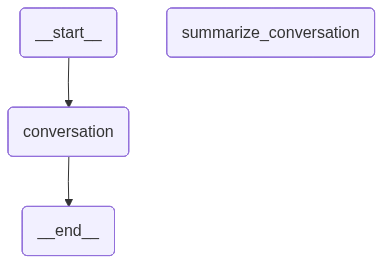

In [3]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0.7)  # Higher temp for creative recommendations

# State 
class State(MessagesState):
    summary: str
    user_preferences: dict  # Track genres, actors, moods user likes

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")
    
    # Base system message for movie bot
    base_system = """You are CineMatch, an enthusiastic and knowledgeable movie recommendation AI. 
    Your role is to:
    - Recommend movies based on user preferences, mood, and past likes
    - Ask insightful questions to understand their taste better
    - Provide brief explanations why you think they'll enjoy each recommendation
    - Remember their preferences across the conversation
    - Be conversational and engaging, like a friend who loves movies
    
    Format your recommendations clearly with:
    • Movie Title (Year) - Genre
    Brief reason why you recommend it based on their preferences.
    """
    
    # If there is summary, then we add it
    if summary:
        # Add summary to system message
        system_message = f"""{base_system}
        
        === Previous Conversation Context ===
        {summary}
        
        Use this context to provide more personalized recommendations."""
        
        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = [SystemMessage(content=base_system)] + state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")
    
    # Create our summarization prompt focused on movie preferences
    if summary:
        # A summary already exists
        summary_message = f"""This is the summary of the movie discussion so far: {summary}

        Update this summary by:
        1. Adding any NEW movie preferences, genres, actors, or themes the user mentioned
        2. Noting which recommendations they responded positively/negatively to
        3. Tracking mood or occasion preferences (e.g., "something light", "date night")
        4. Keeping a compact list of their favorite genres and dislikes
        
        Provide an updated summary focusing on their movie taste profile:"""
        
    else:
        summary_message = """Create a summary of this movie conversation focusing on:
        1. User's preferred genres, actors, directors, or themes
        2. Movies they've mentioned liking or disliking
        3. Current mood or what type of movie they're looking for
        4. Any specific requirements (era, language, length, etc.)
        
        Create a concise taste profile:"""
    
    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than 4 messages, then we summarize to maintain context
    if len(messages) > 4:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


## Createad a thread

In [4]:
# Create a thread for movie recommendations
config = {"configurable": {"thread_id": "10"}}

# Start conversation with the movie bot
for chunk in graph.stream({"messages": [HumanMessage(content="Hi! I'm looking for a good movie to watch tonight, i like action comedies")]}, config, stream_mode="updates"):
    print(chunk)


{'conversation': {'messages': AIMessage(content="Hey there! Action comedies are a great choice for a fun night. Here are a couple of recommendations that you might enjoy:\n\n• **The Nice Guys (2016) - Action/Comedy**  \n   This film is a perfect blend of action, humor, and a bit of mystery. Set in the 1970s, it stars Ryan Gosling and Russell Crowe as an unlikely duo of private investigators. Their chemistry is fantastic, and the witty dialogue will keep you laughing throughout.\n\n• **21 Jump Street (2012) - Action/Comedy**  \n   This movie takes the concept of undercover cops in high school and turns it into a laugh-out-loud adventure. Channing Tatum and Jonah Hill have incredible comedic timing, and the action sequences are both thrilling and hilarious.\n\nDo you have any favorite action comedies you've enjoyed in the past? It might help me tailor my suggestions even more!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 183, 'prompt_toke

## created a multiple dialogue conversation thread, demonstrated memory

In [ ]:

# Create a thread for movie recommendations
config = {"configurable": {"thread_id": "movie_session_1"}}

print("=" * 70)
print(" CONVERSATION 1: Initial greeting")
print("=" * 70)

# First message - user introduces themselves
for chunk in graph.stream(
    {"messages": [HumanMessage(content="Hi! I'm looking for a good thriller movie")]}, 
    config, 
    stream_mode="updates"
):
    print(chunk)

print("\n" + "=" * 70)
print("CONVERSATION 2: Sharing preferences")
print("=" * 70)

# Second message - user shares more preferences
for chunk in graph.stream(
    {"messages": [HumanMessage(content="I love movies like Se7en and Zodiac. Dark, mysterious vibes")]}, 
    config, 
    stream_mode="updates"
):
    print(chunk)

print("\n" + "=" * 70)
print("CONVERSATION 3: Narrowing down")
print("=" * 70)

# Third message - more specific request
for chunk in graph.stream(
    {"messages": [HumanMessage(content="Do you have something similar but maybe a bit newer?")]}, 
    config, 
    stream_mode="updates"
):
    print(chunk)

print("\n" + "=" * 70)
print("CONVERSATION 4: Actor preference")
print("=" * 70)

# Fourth message - actor preference
for chunk in graph.stream(
    {"messages": [HumanMessage(content="I really like Jake Gyllenhaal's performances")]}, 
    config, 
    stream_mode="updates"
):
    print(chunk)

print("\n" + "=" * 70)
print("CONVERSATION 5: Genre expansion")
print("=" * 70)

# Fifth message
for chunk in graph.stream(
    {"messages": [HumanMessage(content="What about psychological thrillers?")]}, 
    config, 
    stream_mode="updates"
):
    print(chunk)

print("\n" + "=" * 70)
print("CONVERSATION 6: Different mood")
print("=" * 70)

# Sixth message
for chunk in graph.stream(
    {"messages": [HumanMessage(content="Actually, maybe something less dark. Something clever but fun?")]}, 
    config, 
    stream_mode="updates"
):
    print(chunk)

print("\n" + "=" * 70)
print("CONVERSATION 7: Specific year range (triggers summarization)")
print("=" * 70)

# Seventh message - this should trigger summarization since we're past 6 messages
for chunk in graph.stream(
    {"messages": [HumanMessage(content="Any good heist movies from the last 5 years?")]}, 
    config, 
    stream_mode="updates"
):
    print(chunk)

print("\n" + "=" * 70)
print("Conversation Complete - Memory has been summarized!")
print("=" * 70)


 CONVERSATION 1: Initial greeting
{'conversation': {'messages': AIMessage(content="Hi there! Thrillers are always exciting. To help me find the perfect recommendation for you, could you tell me a bit about the type of thrillers you enjoy? For instance, do you prefer psychological thrillers, action-packed ones, or something with a bit of mystery? And have there been any thriller movies you've enjoyed in the past?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 132, 'total_tokens': 201, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVDTXkHsR6kx9RqVGlK9bS4im37MS', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--e1a

## started the conversation and tested the memory again

In [6]:
# Start conversation with the movie bot
for chunk in graph.stream({"messages": [HumanMessage(content="Hi! I'm looking for a good movie to watch tonight with mt friend who likes romcoms, also keep my pref in mind")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()


================================== Ai Message ==================================

Hey there! I've got just the thing for a fun movie night that satisfies both your love for clever thrillers and your friend's taste for romcoms:

• **Game Night (2018) - Action, Comedy, Crime**
  This film brilliantly combines elements of a thriller with the humor and charm of a romcom. It follows a group of friends whose regular game night turns into a real-life mystery when they're swept into a web of intrigue and danger. It's packed with clever plot twists and comedic moments, making it a great crossover for both your preferences.

This movie offers the best of both worlds, with a witty script and engaging characters that should keep both you and your friend entertained. Enjoy your movie night!


## created a new thread to demonstrate the stream method where we print the full state, using single convo thread and then a multi convo thread

In [7]:
# Start conversation with a new movie session
config = {"configurable": {"thread_id": "20"}}

# Start conversation
input_message = HumanMessage(content="Hi! I'm in the mood for a sci-fi movie tonight")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)


================================ Human Message =================================

Hi! I'm in the mood for a sci-fi movie tonight
---------------------------------------------------------------------------
================================ Human Message =================================

Hi! I'm in the mood for a sci-fi movie tonight
================================== Ai Message ==================================

Hey there! Sci-fi movies are such a great choice, full of imagination and adventure. To help me find the perfect movie for you, could you tell me a bit more about what you're in the mood for? 

Do you prefer something action-packed, thought-provoking, or maybe a mix of both? And are there any sci-fi movies you've loved in the past?
---------------------------------------------------------------------------


In [ ]:
# Create a thread for movie recommendations
config = {"configurable": {"thread_id": "movie_session_1"}}

print("=" * 70)
print("CONVERSATION 1: Initial greeting")
print("=" * 70)

for chunk in graph.stream(
    {"messages": [HumanMessage(content="Hi! I'm looking for a good thriller movie")]}, 
    config, 
    stream_mode="updates"
):
    for node_name, node_output in chunk.items():
        print(f"\nNode: {node_name}")
        if "messages" in node_output:
            # Check if it's a list or single message
            messages = node_output["messages"]
            if isinstance(messages, list):
                for msg in messages:
                    msg.pretty_print()
            else:
                messages.pretty_print()

print("\n" + "=" * 70)
print(" CONVERSATION 2: Sharing preferences")
print("=" * 70)

for chunk in graph.stream(
    {"messages": [HumanMessage(content="I love movies like Se7en and Zodiac. Dark, mysterious vibes")]}, 
    config, 
    stream_mode="updates"
):
    for node_name, node_output in chunk.items():
        print(f"\nNode: {node_name}")
        if "messages" in node_output:
            messages = node_output["messages"]
            if isinstance(messages, list):
                for msg in messages:
                    msg.pretty_print()
            else:
                messages.pretty_print()

print("\n" + "=" * 70)
print("CONVERSATION 3: Narrowing down")
print("=" * 70)

for chunk in graph.stream(
    {"messages": [HumanMessage(content="Do you have something similar but maybe a bit newer?")]}, 
    config, 
    stream_mode="updates"
):
    for node_name, node_output in chunk.items():
        print(f"\nNode: {node_name}")
        if "messages" in node_output:
            messages = node_output["messages"]
            if isinstance(messages, list):
                for msg in messages:
                    msg.pretty_print()
            else:
                messages.pretty_print()

print("\n" + "=" * 70)
print("CONVERSATION 4: Actor preference")
print("=" * 70)

for chunk in graph.stream(
    {"messages": [HumanMessage(content="I really like Jake Gyllenhaal's performances")]}, 
    config, 
    stream_mode="updates"
):
    for node_name, node_output in chunk.items():
        print(f"\nNode: {node_name}")
        if "messages" in node_output:
            messages = node_output["messages"]
            if isinstance(messages, list):
                for msg in messages:
                    msg.pretty_print()
            else:
                messages.pretty_print()

print("\n" + "=" * 70)
print(" CONVERSATION 5: Genre expansion")
print("=" * 70)

for chunk in graph.stream(
    {"messages": [HumanMessage(content="What about psychological thrillers?")]}, 
    config, 
    stream_mode="updates"
):
    for node_name, node_output in chunk.items():
        print(f"\nNode: {node_name}")
        if "messages" in node_output:
            messages = node_output["messages"]
            if isinstance(messages, list):
                for msg in messages:
                    msg.pretty_print()
            else:
                messages.pretty_print()

print("\n" + "=" * 70)
print("CONVERSATION 6: Different mood")
print("=" * 70)

for chunk in graph.stream(
    {"messages": [HumanMessage(content="Actually, maybe something less dark. Something clever but fun?")]}, 
    config, 
    stream_mode="updates"
):
    for node_name, node_output in chunk.items():
        print(f"\nNode: {node_name}")
        if "messages" in node_output:
            messages = node_output["messages"]
            if isinstance(messages, list):
                for msg in messages:
                    msg.pretty_print()
            else:
                messages.pretty_print()

print("\n" + "=" * 70)
print(" CONVERSATION 7: Specific year range (triggers summarization)")
print("=" * 70)

for chunk in graph.stream(
    {"messages": [HumanMessage(content="Any good heist movies from the last 5 years?")]}, 
    config, 
    stream_mode="updates"
):
    for node_name, node_output in chunk.items():
        print(f"\nNode: {node_name}")
        if node_name == "summarize_conversation":
            print("Summarizing conversation to maintain memory...")
            if "summary" in node_output:
                print(f"📝Summary: {node_output['summary'][:200]}...")
        if "messages" in node_output:
            messages = node_output["messages"]
            if isinstance(messages, list):
                for msg in messages:
                    msg.pretty_print()
            else:
                messages.pretty_print()

print("\n" + "=" * 70)
print("Conversation Complete - Memory has been summarized!")
print("=" * 70)



🎬 CONVERSATION 1: Initial greeting

Node: conversation
================================== Ai Message ==================================

Hello again! Given your love for dark, mysterious thrillers and psychological suspense, I've got a recommendation that should hit the spot:

• **Wind River (2017) - Crime, Drama, Mystery**
  This film is a gripping thriller set in the chilling backdrop of a Wyoming Native American reservation. It follows a seasoned tracker and an FBI agent as they investigate a young woman's murder. The atmospheric setting and intense storyline create a haunting experience, akin to the mood of "Zodiac" and "Se7en." Plus, it's packed with suspense and strong performances that will keep you on the edge of your seat.

I think you'll appreciate the dark, mysterious vibe and intricate plot. Let me know what you think!

Node: summarize_conversation
================================ Remove Message ================================


================================ Remove Mess

In [ ]:

# Start a new movie recommendation session
config = {"configurable": {"thread_id": "movie_session_2"}}

print(" TURN 1: Opening request")
print("=" * 75)
input_message = HumanMessage(content="Hi! I'm in the mood for a sci-fi movie tonight")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

print("\nTURN 2: Adding preferences")
print("=" * 75)
input_message = HumanMessage(content="I loved Interstellar and Arrival. Something thought-provoking")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

print("\n TURN 3: More specifics")
print("=" * 75)
input_message = HumanMessage(content="I prefer movies with great cinematography and emotional depth")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

print("\n TURN 4: Era preference")
print("=" * 75)
input_message = HumanMessage(content="What about something from the 2010s?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

print("\nTURN 5: Director interest")
print("=" * 75)
input_message = HumanMessage(content="I'm a big fan of Denis Villeneuve")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

print("\n TURN 6: Genre shift")
print("=" * 75)
input_message = HumanMessage(content="Actually, what about action sci-fi instead of cerebral?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

print("\n TURN 7: Final request (triggers summarization)")
print("=" * 75)
input_message = HumanMessage(content="Any space-based sci-fi with epic visuals?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

print("\nConversation Complete - Check how your preferences were remembered!")


🎬 TURN 1: Opening request
================================ Human Message =================================

Hi! I'm in the mood for a sci-fi movie tonight
---------------------------------------------------------------------------
================================ Human Message =================================

Hi! I'm in the mood for a sci-fi movie tonight
================================== Ai Message ==================================

Hey there! Sci-fi is such a fantastic genre with endless possibilities. To help narrow it down, could you tell me if you're in the mood for something more action-packed, thought-provoking, or maybe a little bit of both? Also, are there any sci-fi movies you've enjoyed in the past?
---------------------------------------------------------------------------

🎬 TURN 2: Adding preferences
================================ Human Message =================================

Hi! I'm in the mood for a sci-fi movie tonight
================================== Ai Mes

## Streaned the tokens in real time : 

In [ ]:


config = {"configurable": {"thread_id": "streaming_movie_chat"}}
input_message = HumanMessage(content="Give me 3 thriller movie recommendations with detailed descriptions")

print("=" * 75)
print("STREAMING MOVIE RECOMMENDATIONS IN REAL-TIME")
print("=" * 75)
print("\nAsking: 'Give me 3 thriller movie recommendations with detailed descriptions'\n")

async for event in graph.astream_events(
    {"messages": [HumanMessage(content="Give me 3 thriller movie recommendations with detailed descriptions")]}, 
    config, 
    version="v2"
):
    print(f"Event: {event['event']}.get('{event['name']}')), Type: {event['event']}, Name: {event['name']}")
    
    # When the AI model starts streaming
    if event['event'] == 'on_chat_model_stream':
        # Print each token/chunk as it arrives
        print(event['metadata'], end='', flush=True)

print("\n\n" + "=" * 75)
print("Streaming Complete!")
print("=" * 75)



🎬 STREAMING MOVIE RECOMMENDATIONS IN REAL-TIME

Asking: 'Give me 3 thriller movie recommendations with detailed descriptions'

Event: on_chain_start.get('LangGraph')), Type: on_chain_start, Name: LangGraph
Event: on_chain_start.get('conversation')), Type: on_chain_start, Name: conversation
Event: on_chat_model_start.get('ChatOpenAI')), Type: on_chat_model_start, Name: ChatOpenAI
Event: on_chat_model_stream.get('ChatOpenAI')), Type: on_chat_model_stream, Name: ChatOpenAI
{'thread_id': 'streaming_movie_chat', 'langgraph_step': 1, 'langgraph_node': 'conversation', 'langgraph_triggers': ('branch:to:conversation',), 'langgraph_path': ('__pregel_pull', 'conversation'), 'langgraph_checkpoint_ns': 'conversation:28e69c59-155d-cc12-c34c-22bdab65d2e1', 'checkpoint_ns': 'conversation:28e69c59-155d-cc12-c34c-22bdab65d2e1', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o', 'ls_model_type': 'chat', 'ls_temperature': 0.7}Event: on_chat_model_stream.get('ChatOpenAI')), Type: on_chat_model_stream, Nam

## streamed specific token ( only the reccomendations from my bot)

In [11]:
# Stream ONLY the movie recommendations from CineMatch bot


cinematch_node = 'conversation'  # The node we want to stream from
config = {"configurable": {"thread_id": "movie_stream_42"}}
input_message = HumanMessage(content="I loved Interstellar and The Martian. What space movies should I watch next?")

print("=" * 75)
print(" CINEMATCH LIVE STREAM - SPACE MOVIE RECOMMENDATIONS")
print("=" * 75)
print(f" You asked: '{input_message.content}'")
print("-" * 75)
print(" CineMatch: ", end='', flush=True)

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from the CineMatch conversation node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == cinematch_node:
        # event["data"] is the chunk itself, access content directly
        chunk = event["data"]["chunk"]
        if hasattr(chunk, 'content') and chunk.content:
            print(chunk.content, end='', flush=True)

print("\n" + "=" * 75)
print(" Streaming complete")
print("=" * 75)



 CINEMATCH LIVE STREAM - SPACE MOVIE RECOMMENDATIONS
 You asked: 'I loved Interstellar and The Martian. What space movies should I watch next?'
---------------------------------------------------------------------------
 CineMatch: Great choices! Both "Interstellar" and "The Martian" are fantastic films that blend science fiction with a sense of realism and adventure. Since you enjoyed these, I have a few recommendations that might capture your imagination:

• **Gravity (2013) - Sci-Fi, Thriller**  
   This film offers a gripping and visually stunning experience of space survival, with intense and breathtaking sequences that keep you on the edge of your seat.

• **Arrival (2016) - Sci-Fi, Drama**  
   If you appreciated the thought-provoking aspect of "Interstellar," you'll likely enjoy "Arrival." It combines a compelling narrative about communication with aliens and a deep emotional undercurrent.

• **Ad Astra (2019) - Sci-Fi, Adventure**  
   This movie explores the psychological asp

## in langgraph api

In [12]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

## I created a new movie recommendation thread using the langgraph client

In [13]:

thread = await client.threads.create()


input_message = HumanMessage(content="I love mind-bending thrillers like Inception. What should I watch next?")

print("=" * 75)
print("CINEMATCH - STREAMING MOVIE RECOMMENDATIONS VIA SDK")
print("=" * 75)
print(f"Thread ID: {thread['thread_id']}")
print(f"Your query: '{input_message.content}'")
print("-" * 75)

async for event in client.runs.stream(
    thread["thread_id"], 
    assistant_id="agent", 
    input={"messages": [input_message]}, 
    stream_mode="values"
):
    print(event)

print("\n" + "=" * 75)
print("Movie recommendations delivered!")
print("=" * 75)


CINEMATCH - STREAMING MOVIE RECOMMENDATIONS VIA SDK
Thread ID: c02cf234-a248-4c3a-bd27-6af3ce69b5aa
Your query: 'I love mind-bending thrillers like Inception. What should I watch next?'
---------------------------------------------------------------------------
StreamPart(event='metadata', data={'run_id': '019a24ee-3474-7570-84de-adabb82710fc', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'I love mind-bending thrillers like Inception. What should I watch next?', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '0d8b6406-1754-4ae4-97e3-15b76a40e811'}]})
StreamPart(event='values', data={'messages': [{'content': 'I love mind-bending thrillers like Inception. What should I watch next?', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '0d8b6406-1754-4ae4-97e3-15b76a40e811'}, {'content': 'If you\'re a fan of mind-bending thrillers like "Inception," here are some recommendations you might 

## Streamed the result

In [14]:
from langchain_core.messages import convert_to_messages

# movie recommendation session
session = await client.threads.create()
query = HumanMessage(content="Best Christopher Nolan films to watch this weekend?")

print(f"\n CineMatch Session: {session['thread_id'][:8]}...")
#print(f" Query: {query.content}\n")
#print("─" * 60 + "\n")

async for event in client.runs.stream(
    session["thread_id"], 
    assistant_id="agent", 
    input={"messages": [query]}, 
    stream_mode="values"
):
    msgs = event.data.get('messages', None)
    if msgs:
        print(f" {convert_to_messages(msgs)[-1].content}")
    print('═' * 60)





 CineMatch Session: 51e3095e...
════════════════════════════════════════════════════════════
 Best Christopher Nolan films to watch this weekend?
════════════════════════════════════════════════════════════
 Christopher Nolan has directed several critically acclaimed films that are worth watching. Here are some of his best films that you might enjoy:

1. **Inception (2010)** - A science fiction thriller that explores the world of dreams, starring Leonardo DiCaprio.
   
2. **The Dark Knight (2008)** - The second film in Nolan's Batman trilogy, known for Heath Ledger's iconic performance as the Joker.

3. **Interstellar (2014)** - A science fiction epic that delves into space exploration and the survival of humanity, featuring Matthew McConaughey.

4. **Memento (2000)** - A psychological thriller known for its unique narrative structure, starring Guy Pearce.

5. **Dunkirk (2017)** - A war film that portrays the Dunkirk evacuation during World War II, praised for its intense and immersiv

## filtered specific event types :

In [15]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="Give me thriller movie recommendations similar to Gone Girl")

async for event in client.runs.stream(
    thread["thread_id"], 
    assistant_id="agent", 
    input={"messages": [input_message]}, 
    stream_mode="values"
):
    messages = event.data.get('messages', None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('=' * 25)


content='Give me thriller movie recommendations similar to Gone Girl' additional_kwargs={} response_metadata={} id='d41dfe02-7ed0-4edd-b86c-c27cf20e9e64'
content='If you enjoyed "Gone Girl," you might like the following thriller movies which share similar themes of suspense, mystery, and psychological drama:\n\n1. **The Girl on the Train** (2016) - Based on the bestselling novel, this film follows an alcoholic divorcee who becomes entangled in a missing person investigation.\n\n2. **Prisoners** (2013) - A gripping thriller about a father who takes matters into his own hands when his daughter and her friend go missing.\n\n3. **The Girl with the Dragon Tattoo** (2011) - This mystery thriller is in the vein of dark secrets and complex characters, featuring a journalist and a hacker investigating a long-unsolved disappearance.\n\n4. **Zodiac** (2007) - A tense thriller based on the true story of the Zodiac killer, focusing on the reporters and investigators trying to uncover the criminal\'

## Printed Streaming pattern

In [16]:
thread = await client.threads.create()
input_message = HumanMessage(content="Give me thriller movie recommendations similar to Gone Girl")

async for event in client.runs.stream(
    thread["thread_id"], 
    assistant_id="agent", 
    input={"messages": [input_message]}, 
    stream_mode="messages"
):
    print(event.event)


metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
mess

## filtered based on specific types

In [17]:
thread = await client.threads.create()
input_message = HumanMessage(content="Give me thriller movie recommendations similar to Gone Girl")

async for event in client.runs.stream(
    thread["thread_id"], 
    assistant_id="agent", 
    input={"messages": [input_message]}, 
    stream_mode="messages"
):
    # Only print complete messages, skip partial/metadata
    if "metadata" in event.event:
        print(event.event)


metadata
messages/metadata


## tracked and counted events

In [18]:
thread = await client.threads.create()
input_message = HumanMessage(content="Best Christopher Nolan films ranked")

event_counter = 0

async for event in client.runs.stream(
    thread["thread_id"], 
    assistant_id="agent", 
    input={"messages": [input_message]}, 
    stream_mode="messages"
):
    event_counter += 1
    print(f"[Event {event_counter}] {event.event}")


[Event 1] metadata
[Event 2] messages/metadata
[Event 3] messages/partial
[Event 4] messages/partial
[Event 5] messages/partial
[Event 6] messages/partial
[Event 7] messages/partial
[Event 8] messages/partial
[Event 9] messages/partial
[Event 10] messages/partial
[Event 11] messages/partial
[Event 12] messages/partial
[Event 13] messages/partial
[Event 14] messages/partial
[Event 15] messages/partial
[Event 16] messages/partial
[Event 17] messages/partial
[Event 18] messages/partial
[Event 19] messages/partial
[Event 20] messages/partial
[Event 21] messages/partial
[Event 22] messages/partial
[Event 23] messages/partial
[Event 24] messages/partial
[Event 25] messages/partial
[Event 26] messages/partial
[Event 27] messages/partial
[Event 28] messages/partial
[Event 29] messages/partial
[Event 30] messages/partial
[Event 31] messages/partial
[Event 32] messages/partial
[Event 33] messages/partial
[Event 34] messages/partial
[Event 35] messages/partial
[Event 36] messages/partial
[Event 3

## Extracted and printed event data differently

In [19]:
thread = await client.threads.create()
input_message = HumanMessage(content="Psychological thriller recommendations")

async for event in client.runs.stream(
    thread["thread_id"], 
    assistant_id="agent", 
    input={"messages": [input_message]}, 
    stream_mode="messages"
):
    # Print both event type and data if available
    print(f"Type: {event.event}")
    if hasattr(event, 'data'):
        print(f"Data: {event.data}")


Type: metadata
Data: {'run_id': '019a24ee-e633-73e0-95c7-ee38363aa75d', 'attempt': 1}
Type: messages/metadata
Data: {'lc_run--ed1f095b-a98f-4d34-a304-5e1d2d0b1d11': {'metadata': {'created_by': 'system', 'graph_id': 'agent', 'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca', 'run_attempt': 1, 'langgraph_version': '0.6.10', 'langgraph_api_version': '0.4.42', 'langgraph_plan': 'developer', 'langgraph_host': 'self-hosted', 'langgraph_api_url': 'https://keyboards-participate-arthur-expertise.trycloudflare.com', 'langgraph_auth_user_id': '', 'langgraph_request_id': '5ddab586-ed87-4ba0-8cc0-3591d3f96f4c', 'run_id': '019a24ee-e633-73e0-95c7-ee38363aa75d', 'thread_id': 'f6d9c11e-77b2-4061-8d0c-836bfd357771', 'user_id': '', 'langgraph_step': 1, 'langgraph_node': 'assistant', 'langgraph_triggers': ['branch:to:assistant'], 'langgraph_path': ['__pregel_pull', 'assistant'], 'langgraph_checkpoint_ns': 'assistant:dfc7ff2e-8f7f-1549-c866-eb237007f5d3', 'checkpoint_ns': 'assistant:dfc7ff2e-8f7f-154

## defined this tool and streamed the tool calls

In [20]:
thread = await client.threads.create()
input_message = HumanMessage(content="Give me thriller movie recommendations similar to Gone Girl with plot twists")


def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"


# Track response statistics
response_count = 0
total_tool_calls = 0

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",
):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                response_count += 1
                
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"CineMatch [{response_count}]: {content}")

                if tool_calls:
                    total_tool_calls += len(tool_calls)
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

# Print summary after streaming
print(f"\nSummary: {response_count} responses | {total_tool_calls} tool calls made")



Metadata: Run ID - 019a24ee-f61b-761a-ad1b-220e0842a344
--------------------------------------------------
Response Metadata: Finish Reason - N/A
--------------------------------------------------
CineMatch [2]: If
Response Metadata: Finish Reason - N/A
--------------------------------------------------
CineMatch [3]: If you
Response Metadata: Finish Reason - N/A
--------------------------------------------------
CineMatch [4]: If you enjoyed
Response Metadata: Finish Reason - N/A
--------------------------------------------------
CineMatch [5]: If you enjoyed "
Response Metadata: Finish Reason - N/A
--------------------------------------------------
CineMatch [6]: If you enjoyed "Gone
Response Metadata: Finish Reason - N/A
--------------------------------------------------
CineMatch [7]: If you enjoyed "Gone Girl
Response Metadata: Finish Reason - N/A
--------------------------------------------------
CineMatch [8]: If you enjoyed "Gone Girl"
Response Metadata: Finish Reason - N/A
---